## Look Inside CNN

### MNIST

In [2]:
import numpy as np
import torch
import torch.nn as nn # Conv2d, BatchNorm2d
import torch.nn.functional as F # F.softmax
import torchvision # To download dataset
import torchvision.transforms as transforms #data preprocessing, (to tensor, rotate)
# data preprocessing에서 transform : 데이터 증강을 위해서이다. skew, rotate등의 기법을 활용하여 과적합 완화


import matplotlib
import matplotlib.pyplot as plt

from matplotlib.pyplot import imshow

### 1. Define Hyper-parameters and pre-set device on cuda

In [3]:
print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
!python -c 'import platform;print(platform.platform())'

PyTorch version:1.13.0
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True
macOS-10.16-x86_64-i386-64bit


In [4]:
# Device Configuration
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
# 나중에 학습 전에 데이터를 gpu에 넣고 학습하기 위함 -> 모델과 데이터가 같은 device에 있어야 한다
# images.to(device)를 사용해서 학습하게 된다 (추후에)
# model.to(device) 모델과 데이터가 같은 저장공간에 있는지 주의해야 한다.
# cuda : Nvidia GPU에서만 사용가능하다
print(f"device: {device}")
# Adjust Dataset classes and channels
num_classes = 10
in_channel = 1 # RGB라면 3이 될 것이고, 흑백이라면 1이 될 것이다.

# Hyper-parameters 
batch_size = 50 # 성능이 좋지 않은 컴퓨터면 16이상으로는 돌리기 힘들다
max_pool_kernel = 2
learning_rate = 0.0001 #0.01 ~ 0.0001
num_epochs = 5 #Overfitting 나오는 것에 주의한다 + Overfitting이 발생할 때 어떻게 다룰 것인가?

device: mps:0


2차 과제에서 Hyperparameter의 중요성이 커질 것이니 주의한다.

### 2. Load Data

In [5]:
import torch
train_data = torchvision.datasets.MNIST(root='./datasets', #directory 입력, 이미지가 들어있는 folder
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)

test_data = torchvision.datasets.MNIST(root='./datasets',
                                       train=False,
                                       transform=transforms.ToTensor(),
                                       download=True)

### 3. Define Dataloader

In [6]:
len(train_data), len(test_data)

(60000, 10000)

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                          batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)             # torch 의 data loader를 그대로 불러와 사용

### 4. Define Model

In [8]:
class ConvNetStep(nn.Module):
    def __init__(self, num_classes = 10):
        super(ConvNetStep, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = in_channel, 
                      out_channels = 16, 
                      kernel_size = 5, stride = 1, padding = 2),
            #nn.Conv2d(1, 16, 5, padding = 2)와 같은 내용의 코드이다.
            nn.BatchNorm2d(num_features=16),
            #하나의 Batch마다 Normalization을 진행한다.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=max_pool_kernel)
        ) #결과적으로 사이즈가 절반으로 줄어든다
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 32, 
                      kernel_size = 5, stride = 1, padding = 2),
            nn.BatchNorm2d(num_features = 32), #BatchNorm은 out_channels와 같아야 한다
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = max_pool_kernel)
        ) # Layer는 총 두개 사용한다 
        # fc1 직전의 data shape : 32 * 7 * 7, 오류가 뜰 경우 직전 layer의 output channel 사이즈를 조정해도 된다
        self.fc1 = nn.Linear(in_features = 32*7*7, out_features = 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = num_classes) #num_classes = 10

    def forward1(self, x):
        x = self.layer1(x)
        return x
  
    def forward2(self, x):
        x = self.layer2(x)
        return x

    def forward3(self, x):
        x = x.reshape(x.size(0),-1) # Vectorization
        return self.fc1(x)

    def forward4(self, x):
        return self.fc2(x)

    def forward(self, x):    # 실제 학습 시에는 이 함수만 사용
        x = self.layer1(x) # 1*28*28 -> 16*14*14
        x = self.layer2(x) # 16*14*14 -> 32*7*7 (3D tensor)

        x = F.relu(x)
        x = x.reshape(x.size(0),-1) # Batchsize*(x.size)32*7*7 -> 1568 (vectorization)
        x = F.relu(self.fc1(x)) # 1568 -> 120
        x = self.fc2(x) # 120 -> 10
        return x

model = ConvNetStep()

### 4.1 Inside CNN

#### 4.1.1 Row Image (MNIST)

In [9]:
%matplotlib inline
def image_show(tensor_image):
    image = tensor_image.reshape(tensor_image.size()[1], tensor_image.size()[2])    # width x height
    imshow(image, cmap='gray')

images, labels = next(iter(train_loader))
image1, label1 = images[0], labels[0]
image2, label2 = images[1], labels[1]

Text(0.5, 1.0, 'tensor(1)')

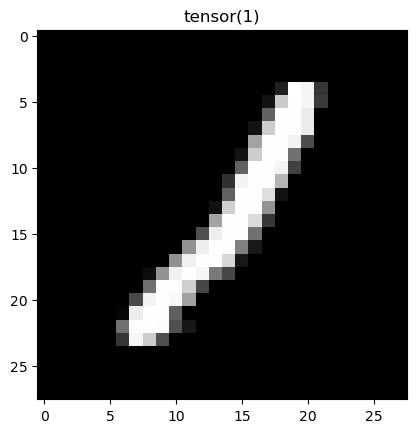

In [10]:
image_show(image1)
plt.title(label1)

Text(0.5, 1.0, 'tensor(1)')

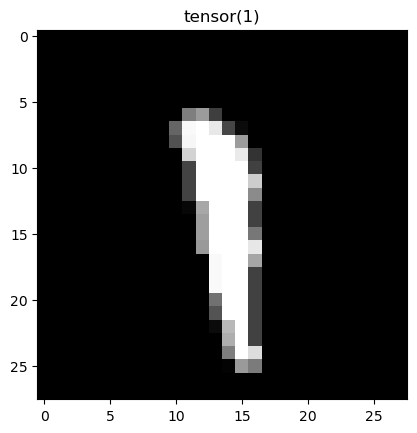

In [11]:
image_show(image2)
plt.title(label2)

#### 4.1.2 After first convolution layer

In [12]:
model.eval()
output1 = model.forward1(images)
print(f"{images.size()} --> {output1.size()}")

torch.Size([50, 1, 28, 28]) --> torch.Size([50, 16, 14, 14])


In [13]:
image1, image2 = output1[0], output1[1]
print(image1.size(), image2.size())

torch.Size([16, 14, 14]) torch.Size([16, 14, 14])


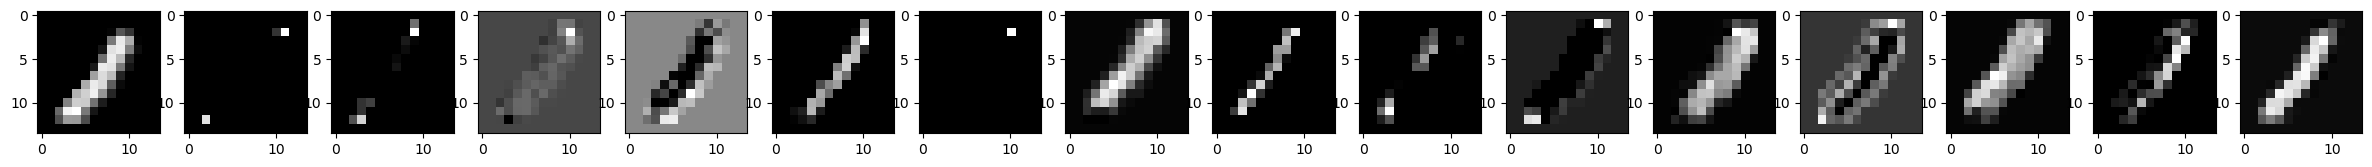

In [14]:
fig = plt.figure(figsize=(30,30))

for i in range(len(image1)):
    plt.subplot(1,len(image1),i+1)
    plt.imshow(image1[i].detach().numpy(), cmap='gray')

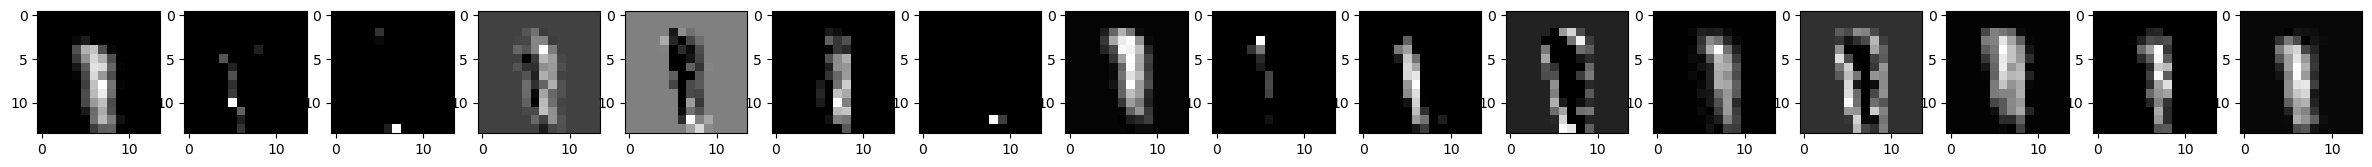

In [15]:
fig = plt.figure(figsize=(30,30))

for i in range(len(image2)):
    plt.subplot(1,len(image2),i+1)
    plt.imshow(image2[i].detach().numpy(), cmap='gray')

#### 4.1.3 After second convolution layer

In [16]:
output2 = model.forward2(output1)
print(f"{output1.size()} --> {output2.size()}")

torch.Size([50, 16, 14, 14]) --> torch.Size([50, 32, 7, 7])


In [17]:
image1, image2 = output2[0], output2[1]

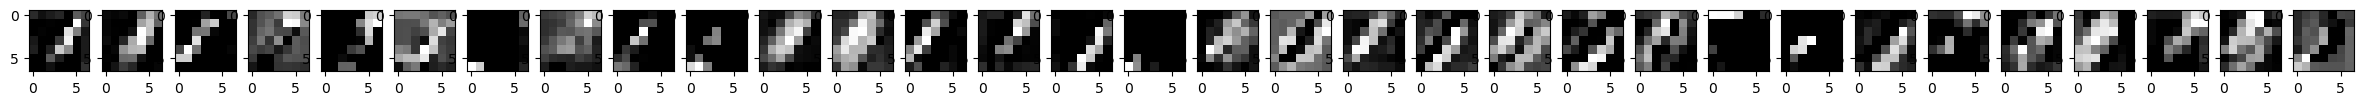

In [18]:
fig = plt.figure(figsize=(30,30))

for i in range(len(image1)):
    plt.subplot(1,len(image1),i+1)
    plt.imshow(image1[i].detach().numpy(), cmap='gray')

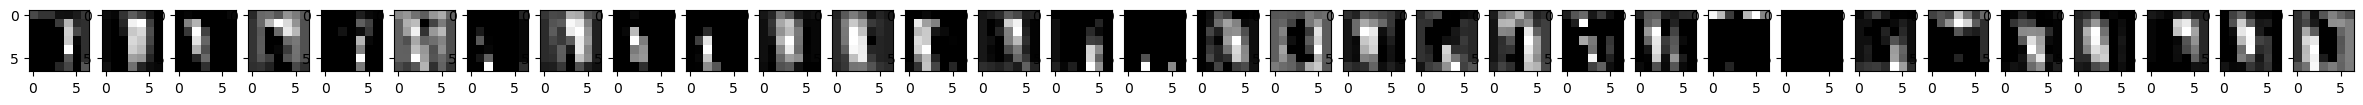

In [19]:
fig = plt.figure(figsize=(30,30))

for i in range(len(image2)):
    plt.subplot(1,len(image2),i+1)
    plt.imshow(image2[i].detach().numpy(), cmap='gray')

Layer 2번을 돌려도 어느정도 특성이 잔존해 있다

#### 4.1.4 After third Fully Connected Layer

In [ ]:
output3 = model.forward3(output2)
print(f"{output2.size()} --> {output3.size()}")

In [ ]:
image1, image2 = output3[0], output3[1]

print(image1.size(), image2.size())


> error : image1가 더 이상 2차원 tensor가 아님. (이미지로 show 불가)

plt.imshow(image1[0].detach().numpy())

In [ ]:
print(image1) # 단일 1D Tensor로 변환되어 있다

120개의 element가 출력된다

#### 4.1.5 After forth Fully Connected Layer

In [ ]:
output4 = model.forward4(output3)
print(f"{output3.size()} --> {output4.size()}")

In [ ]:
image1, image2 = output4[0], output4[1]
print(image1.size())
print(image2.size())

In [ ]:
print("image1")
print("the final tensor :", image1)
print("the result prediction:", image1.tolist().index(image1.max()))
print("the original label:", label1)

In [ ]:
print("image2")
print("the final tensor:", image2)
print("the result prediction:", image2.tolist().index(image2.max()))
print("the original label:", label2)

최종적으로 10개의 element로 구성된 1D Tensor가 출력된다. 최종결과가 0 근처에 있는 이유는 바로 Normalization 때문이다.

### 5. Set Loss & Optimizer

In [ ]:
model = ConvNetStep().to(device) # to device 주의
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # 지정한 learning rate에 따라 학습을 시킨다

### 6. Train

In [ ]:
total_step = len(train_loader)
total_loss = []
model.train()
for epoch in range(num_epochs):
    epoch_loss = []
    for i, (img, label) in enumerate(train_loader):
        # Assign Tensors to Configures Devices (gpu)
        img = img.to(device)
        label = label.to(device)

        # Forward propagation
        outputs = model(img)

        # Get Loss, Compute Gradient, Update Parameters
        loss = criterion(outputs, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.detach().cpu().numpy()) 
        # loss는 gpu 상에 존재, detach().cpu()로 불러온 뒤, numpy()를 통해 ndarray로 바꾸어 주어야 한다 
        # Print Loss
        if i % 10000 == 0 or (i+1)==len(train_loader):
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, 
                                                                     i+1, len(train_loader), loss.item()))
    total_loss.append(np.mean(epoch_loss))
    print(f"epoch{i} loss: {np.mean(epoch_loss)}")

Epoch이 끝날 때마다 loss가 계속 줄어든다

In [ ]:
import seaborn as sns
sns.set_style("dark")
plt.figure(figsize = (8,5))
plt.plot(total_loss)
plt.title("MNIST CNN loss example", fontweight='bold', fontfamily='Serif')
plt.show()

### 7. Save Model and Load Model to test

### 7.1 Save Model

In [ ]:
torch.save(model.state_dict(),"my_model.pth")   # model의 weight 정보 만을 저장

### 7.2 Load Model

In [ ]:
test_model = ConvNetStep().to(device)

test_model.load_state_dict(torch.load("my_model.pth"))   # test_model이라는 모델 안에 앞서 학습한 weight 정보가 담기게 된다.

In [ ]:
test_model.eval()

with torch.no_grad():
    correct = 0
  
    for img, lab in test_loader :
        img = img.to(device)
        lab = lab.to(device)
        out = test_model(img)
        _, pred = torch.max(out.data, 1)
        correct += (pred == lab).sum().item()

    print("Accuracy of the network on the {} test images: {}%".format(len(test_loader)*batch_size, 
                                                                      100 * correct / 
                                                                      (len(test_loader) * 
                                                                       batch_size)))

저장하고 불러오기로 완전히 똑같은 가중치를 가지는 모델을 불러올 수 있다